# Model Training

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import Flatten, Add, ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.python.keras.utils.data_utils import Sequence

In [ ]:
# Path for the simulation data and noisy data with background
feature_path='.../spectra_sheet_crop_2.8kev_with_BG.csv'
feature_path2='.../spectra_sim_1_with_BG.csv'
tbl = pd.read_csv(feature_path)
tbl = tbl.set_index('ID')
print(tbl.shape)

tbl2 = pd.read_csv(feature_path2)
tbl2 = tbl2.set_index('ID')
tbl2.shape

(16224, 3815)


(16224, 3815)

In [ ]:
tbl.head(3)

,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,...,feature_4086,feature_4087,feature_4088,feature_4089,feature_4090,feature_4091,feature_4092,feature_4093,feature_4094,feature_4095
ID,,,,,,,,,,,,,,,,,,,,,
0,0.336296,0.362685,0.410058,0.468601,0.547840,0.662325,0.788900,0.920894,1.049247,1.160625,...,-9.490000e-07,-9.510000e-07,-9.530000e-07,-9.550000e-07,-9.570000e-07,-9.590000e-07,-9.610000e-07,-9.630000e-07,-9.650000e-07,-9.670000e-07
1,0.341021,0.371070,0.423037,0.486664,0.570651,0.688407,0.815564,0.944555,1.066089,1.167499,...,8.200000e-07,8.210000e-07,8.220000e-07,8.230000e-07,8.240000e-07,8.250000e-07,8.260000e-07,8.270000e-07,8.280000e-07,8.290000e-07
2,0.444545,0.489398,0.549174,0.608149,0.670369,0.746924,0.815075,0.873504,0.923369,0.964493,...,1.050000e-06,1.050000e-06,1.050000e-06,1.050000e-06,1.050000e-06,1.050000e-06,1.060000e-06,1.060000e-06,1.060000e-06,1.060000e-06


In [ ]:
import tensorflow as tf
tf.test.is_gpu_available()

True

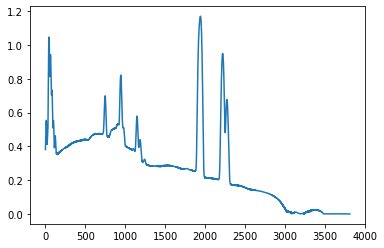

In [ ]:
def read_features(ID, desired_size = (4096,1), alpha = 0.5):
    try:    
        if alpha < 0.3:
            row = tbl2.loc[ID,:]
            row[row < 2] = 0
            row = np.log1p(np.log1p(np.sqrt(row)))
#             row = np.log1p(row)
            row = np.expand_dims(row, axis = -1)            
        else:  
            row = tbl.loc[ID,:]
            row[row < 0] = 0
            row = np.log1p(np.log1p(np.sqrt(row)))
#             row = np.log1p(row)
            row = np.expand_dims(row, axis = -1)
    except:
        row = np.zeros(desired_size)        
    return row

a = read_features(400, (200,1), 0.7)
a.shape

xx = np.linspace(281, 4096, 3815)
plt.plot(a)
# plt.xlim([281, 4096])
# a.shape

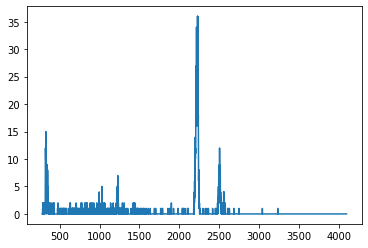

In [ ]:
row = tbl2.loc[400,:]
row = np.expand_dims(row, axis = -1)     
xx = np.linspace(281, 4096, 3815)
plt.plot(xx, row)

In [ ]:
# read labels (groundtruth)
gt_path='.../large_label_13.csv'
gt = pd.read_csv(gt_path)
gt = gt.set_index('ID')
gt.shape

(16224, 13)

In [ ]:
def read_gt(ID, desired_size = (13,1)):
    try:
        row = gt.loc[ID,:]
#         row = np.expand_dim(row, axis = -1)
    except:
        row = np.zeros(desired_size)  
    
    return row
a = read_gt(400, (13,1))
a.shape

(13,)

In [ ]:
a

Cadmium yellow      1
Chromate yellow     0
Chromate green      0
Cobalt blue         0
Emerald green       0
Iron oxide          0
Lead White          1
Prussian blue       0
Red lead            0
SnO2                0
Ultramarine blue    0
Vermilion           0
ZnO                 0
Name: 400, dtype: int64

In [ ]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=64, dim=tbl.shape[1], n_channels=1,
                     augment =False, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y   
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim, self.n_channels))
        y = np.empty((self.batch_size, 13), dtype=np.float32)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            if self.augment:
                alpha = np.random.uniform(0,1)
            else:
                alpha = 0.8
            XXX = read_features(ID, alpha=alpha)
            X[i,] = XXX

            y[i,] = read_gt(ID)

        return X, y

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tbl, gt, test_size=0.20, random_state=42)

In [ ]:
train_generator  = DataGenerator(X_train.index, 64, X_train.shape[1], 1, augment =True, shuffle=True)
valid_generator = DataGenerator(X_test.index, 64, X_test.shape[1], 1, shuffle=False)

In [ ]:
model = keras.Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation = 'relu',input_shape=(tbl.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2 ))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2 ))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2 ))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2 ))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2 ))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.25))
# model.add(Dense(256, activation='relu'))
model.add(Dense(13, activation="sigmoid", name='dense_output'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3811, 64)          384       
_________________________________________________________________
batch_normalization (BatchNo (None, 3811, 64)          256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1905, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1903, 64)          12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1903, 64)          256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 951, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 949, 64)           1

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
es = EarlyStopping(monitor='val_accuracy', 
                   verbose=1, 
                   patience=10, 
                   min_delta=0.00001, 
                   mode='max')
mc = ModelCheckpoint('.../model/model_deeper_bg_13.hdf5', 
                     monitor='val_accuracy', 
                     verbose=1, 
                     save_best_only=True, 
                     mode='max')
rlr = ReduceLROnPlateau(monitor='val_accuracy',
                        mode='max',
                        factor=0.1,
                        patience=10)

In [ ]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.0001),
              metrics=['accuracy'])

In [ ]:
history =model.fit_generator(train_generator, epochs=100,verbose=1, max_queue_size=1, 
                               workers=1, validation_data=valid_generator,
                                callbacks = [es, mc,rlr],use_multiprocessing=False)

Epoch 1/100
201/202 [============================>.] - ETA: 0s - loss: 0.3366 - accuracy: 0.8847
Epoch 00001: val_accuracy improved from -inf to 0.58863, saving model to /home/yunan/Pigment/model/model_deeper_bg_13.hdf5
202/202 [==============================] - 81s 399ms/step - loss: 0.3363 - accuracy: 0.8848 - val_loss: 0.6750 - val_accuracy: 0.5886
Epoch 2/100
201/202 [============================>.] - ETA: 0s - loss: 0.2630 - accuracy: 0.9107
Epoch 00002: val_accuracy improved from 0.58863 to 0.73990, saving model to /home/yunan/Pigment/model/model_deeper_bg_13.hdf5
202/202 [==============================] - 75s 372ms/step - loss: 0.2630 - accuracy: 0.9108 - val_loss: 0.5640 - val_accuracy: 0.7399
Epoch 3/100
201/202 [============================>.] - ETA: 0s - loss: 0.2469 - accuracy: 0.9151
Epoch 00003: val_accuracy improved from 0.73990 to 0.86192, saving model to /home/yunan/Pigment/model/model_deeper_bg_13.hdf5
202/202 [==============================] - 78s 386ms/step - loss: 

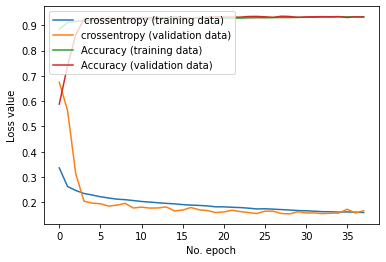

In [ ]:
# Plot history: Categorical crossentropy & Accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label=' crossentropy (training data)')
plt.plot(history.history['val_loss'], label='crossentropy (validation data)')
plt.plot(history.history['accuracy'], label='Accuracy (training data)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
# plt.title('Model performance for 3D MNIST Keras Conv3D example')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

plt.show()

In [ ]:
model.load_weights('.../model/model_deeper_bg_13.hdf5')

In [ ]:
test_generator = DataGenerator(X_test.index, 1, X_test.shape[1], 1, shuffle=False)
r = model.predict_generator(test_generator)

In [ ]:
result = (r>0.5)*1.0                     
result.shape

(3245, 13)

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
print(classification_report(y_test['Chromate yellow'], result[:,-2]))

In [ ]:
classes = y_test.columns
classes.shape

(13,)

In [ ]:
Acc = []
pre = []
f1 = []
recall = []

In [3]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

for i in range(13):
    ex = classes[i]
    print('{}_acc: {}'.format(ex, accuracy_score(result[:,i], y_test[classes[i]])))
    Acc.append( accuracy_score(result[:,i], y_test[classes[i]]))
    print('{}_preci: {}'.format(ex, precision_score(result[:,i], y_test[classes[i]])))
    pre.append( precision_score(result[:,i], y_test[classes[i]]))
    print('{}_f1: {}'.format(ex, f1_score(result[:,i], y_test[classes[i]])))
    f1.append( f1_score(result[:,i], y_test[classes[i]]))
    print('{}_recall: {}'.format(ex, recall_score(result[:,i], y_test[classes[i]])))
    recall.append( recall_score(result[:,i], y_test[classes[i]]))
    print(classification_report(y_test[classes[i]], result[:,i]))
    print('************************************')

In [ ]:
# probability map (uncertainty score mappings)
for i in range(11):
    ex = classes[i]
    error_1 = []
    error_0 = []
    print(ex)
    for j in range(3245):
        if y_test.values[j][i] == 1:
            error_1.append(1 - r[j][i])
        else:
            error_0.append(r[j][i])
    print('1', sum(error_1)/len(error_1))
    print('0', sum(error_0)/len(error_0))
            
            

Cadmium yellow
1 0.00012124626260054738
0 5.587774063275609e-05
Cobalt blue
1 0.28986273669934537
0 0.03718450840656048
Emerald green
1 0.14847498182757493
0 0.04855873883953597
Iron oxide
1 0.5406385731673048
0 0.09356863596691743
Prussian blue
1 0.5812939950652214
0 0.07947680071769256
SnO1
1 8.994543806035468e-05
0 1.1847115851737358e-05
Ultramarine blue
1 0.28632419664195496
0 0.04287376677407197
Vermilion
1 0.039209325233595424
0 0.003324511843179003
ZnO
1 0.24480176378260196
0 0.03621554003323862
Chromate
1 0.2519431875575203
0 0.04931555718634132
Lead
1 0.1717772127923826
0 0.08162016141204363


# Visualizations

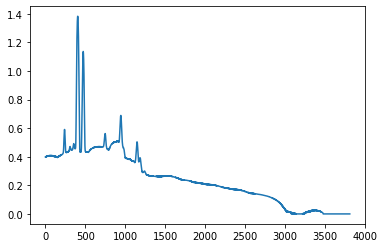

In [ ]:
IIDD = 1000

a = read_features(IIDD, (4096,1), 0.5)  # 8000
plt.plot(a)
a.shape
a = np.expand_dims(a, axis = 0)

In [ ]:
res_a = model.predict(a)

In [ ]:
res_a

array([[2.7120113e-06, 9.9713302e-01, 6.7055225e-06, 2.4045765e-02,
        1.7833832e-01, 0.0000000e+00, 1.7881393e-07, 5.9604645e-08,
        8.1980970e-06, 8.4586167e-01, 2.7057182e-03]], dtype=float32)

In [ ]:
gt_a = read_gt(IIDD, (11,1))
gt_a

Cadmium yellow      0
Cobalt blue         1
Emerald green       0
Iron oxide          0
Prussian blue       0
SnO1                0
Ultramarine blue    0
Vermilion           0
ZnO                 0
Chromate            1
Lead                0
Name: 1000, dtype: int64

In [ ]:
target_class = np.argmax(res_a)
# target_class = 8
print(target_class)

1


In [ ]:
last_conv = model.get_layer('conv1d_5') 
grad_model = tf.keras.models.Model([model.inputs], [last_conv.output, model.output])

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(a)
    #get activations maps + predictions from last conv layer
    loss = predictions[:, target_class] 
    # the variable loss gets the probability of belonging to the defined class (the predicted class on the model output)

In [ ]:
output = conv_outputs[0] #activations maps from last conv layer
grads = tape.gradient(loss, conv_outputs) #function to obtain gradients from last conv layer

print("grads shape:", grads.shape)
print("Model output (loss for the target class):", loss.shape)
print("Output froom lat conv layer", conv_outputs.shape)

grads shape: (1, 115, 128)
Model output (loss for the target class): (1,)
Output froom lat conv layer (1, 115, 128)


(1, 115, 128)


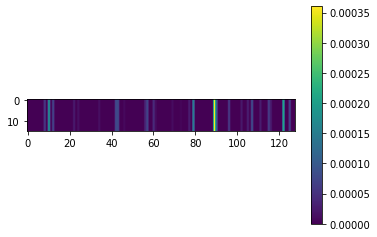

In [ ]:
# Apply guided backpropagation
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

print(guided_grads.shape)
guide_grads_example = guided_grads[:,0,:]
# print(guide_grads_example.shape)
guide_grads_example = np.squeeze(guide_grads_example, 0)
# plt.plot(np.squeeze(guide_grads_example, 0)) 
plt.show() 

guided_grads_image = [guide_grads_example,guide_grads_example,guide_grads_example, guide_grads_example,guide_grads_example,
                        guide_grads_example,guide_grads_example,guide_grads_example, guide_grads_example,guide_grads_example,
                        guide_grads_example,guide_grads_example,guide_grads_example, guide_grads_example,guide_grads_example]
plt.imshow(guided_grads_image) # vmin=-1, vmax=1) #cmap='gray
plt.colorbar()

In [ ]:
weights = tf.reduce_mean(guided_grads, axis=(0,1))
#print("weights shape", weights.shape) 
print("min", np.min(weights))
print("max", np.max(weights))

#plt.plot(weights) 
#plt.show() 

#Weight of each filter in the conv layer 
weights

min 2.3365192e-06
max 3.2166194e-05


<tf.Tensor: id=16814, shape=(128,), dtype=float32, numpy=
array([1.00392508e-05, 4.77220874e-06, 1.16232768e-05, 2.60687057e-06,
       6.47260822e-06, 6.69180054e-06, 2.96813760e-05, 1.47612054e-05,
       7.43313740e-06, 2.47244807e-05, 1.16396677e-05, 1.01700689e-05,
       1.55589078e-05, 1.32223577e-05, 5.15588317e-06, 1.65294423e-05,
       8.58544718e-06, 1.71307365e-05, 8.21854064e-06, 3.03055413e-06,
       7.92404990e-06, 5.08350195e-06, 1.23292002e-05, 4.44932130e-06,
       2.04648659e-05, 3.21661937e-05, 1.31016614e-05, 9.93094181e-06,
       4.57658734e-06, 1.54273694e-05, 1.43652105e-05, 9.82897200e-06,
       2.64447954e-05, 1.47705077e-05, 1.56078331e-05, 2.33008559e-05,
       6.68304710e-06, 1.04733408e-05, 2.41842408e-05, 1.28680413e-05,
       1.63636032e-05, 2.76912397e-06, 1.20189952e-05, 2.19897229e-05,
       1.40853062e-05, 1.69351042e-05, 7.94693733e-06, 1.40069378e-05,
       1.03800585e-05, 1.39510312e-05, 1.16245210e-05, 1.10446881e-05,
       8.62531033e-

min 1.0001570610911585
max 1.0016368138603866


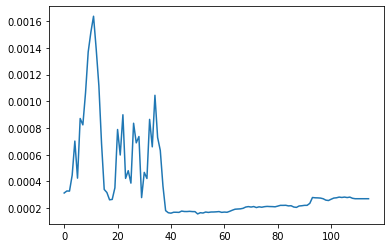

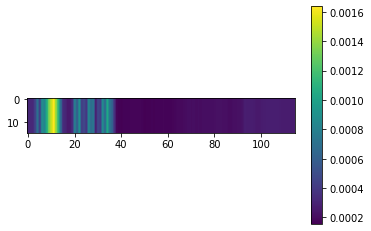

In [ ]:
cam = np.zeros(output.shape[0], dtype = np.float128)
cam
# print(cam.shape)
for i, w in enumerate(weights):
#     print(w)
    cam += w * output[:, i]
#     print(cam)
    
print("min", np.min(cam) + 1.0)
print("max", np.max(cam) + 1.0)

plt.plot(cam) 
plt.show() 

cam_image = [cam,cam,cam,cam,cam,
            cam,cam,cam,cam,cam,
             cam,cam,cam,cam,cam]
plt.imshow(cam_image) # vmin=-1, vmax=1) #cmap='gray
plt.colorbar()

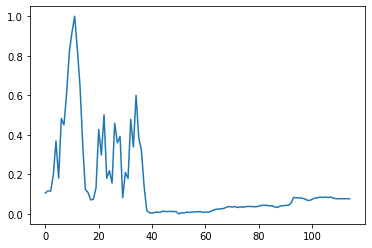

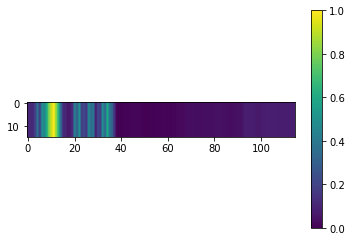

In [ ]:
cam = np.maximum(cam, 0)
cam = (cam - cam.min()) / (cam.max() - cam.min())

plt.plot(cam) 
plt.show()

cam_image = [cam,cam,cam,cam,cam,
            cam,cam,cam,cam,cam,
             cam,cam,cam,cam,cam]
plt.imshow(cam_image) 
plt.colorbar()
plt.show()

# b =  signal.resample(a[0,:,0], 128)
# b.shape

# plt.plot(b)
# plt.plot(cam, c = 'red')

In [ ]:
a.shape

(1, 3815, 1)

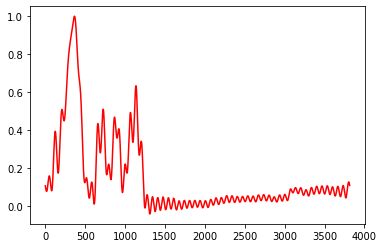

In [ ]:
from scipy import signal
f = signal.resample(cam, 3815)
# plt.plot(a[0,:,0])
plt.plot(f, c = 'red')

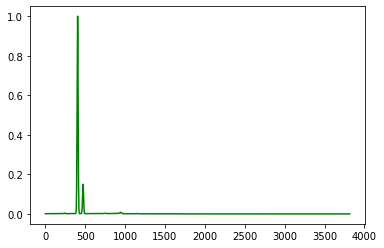

In [ ]:
from scipy import signal
f = signal.resample(cam, 3815)

# plt.plot(f, c = 'red')

row = tbl.loc[IIDD,:]
row[row < 0] = 0
row = (row - np.min(row))/(np.max(row)-np.min(row))
row = np.expand_dims(row, axis = -1)

plt.plot(row, c = 'green')

In [ ]:
a.shape

(1, 3815, 1)

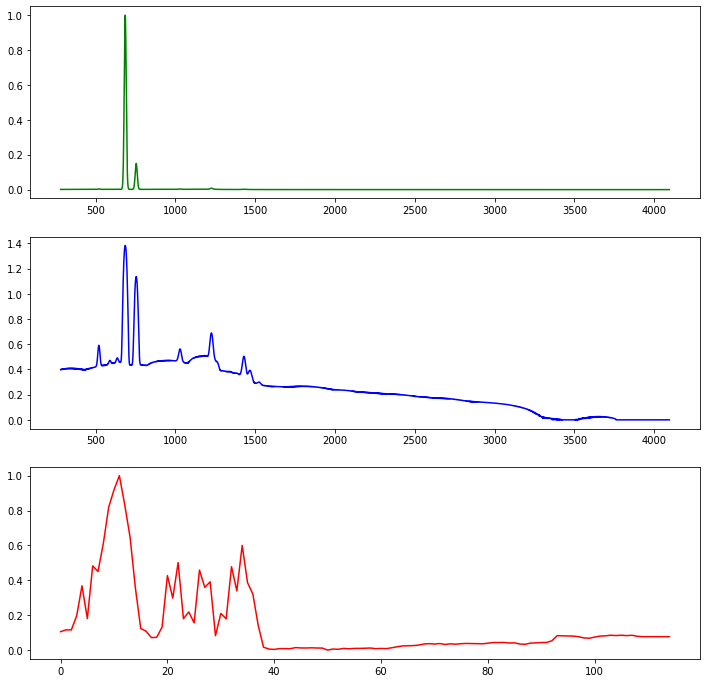

In [ ]:
xx = [i for i in range(281, 281+3815)]

plt.figure(figsize = (12,12))
plt.subplot(3,1,1)
plt.plot(xx,row, c = 'green')

plt.subplot(3,1,2)
plt.plot(xx, a[0,:,0], c = 'blue')

plt.subplot(3,1,3)
plt.plot(cam, c = 'red')

# Mistakes

In [ ]:
predicted = pd.DataFrame(data=result[:,:], index=y_test.index, columns=y_test.columns)  # 1st row as the column names

In [ ]:
y_test['Emerald green'] == result[:,2]

ID
4679     True
2805     True
1683     True
862      True
14444    True
         ... 
15494    True
10083    True
8183     True
14155    True
6339     True
Name: Emerald green, Length: 3245, dtype: bool

In [ ]:
cobalt_blue = y_test['Emerald green'] == result[:,2]

In [ ]:
temp = predicted[cobalt_blue == False]
temp
# temp[temp['Cobalt blue'] == True]

,Cadmium yellow,Cobalt blue,Emerald green,Iron oxide,Prussian blue,SnO1,Ultramarine blue,Vermilion,ZnO,Chromate,Lead
ID,,,,,,,,,,,
7747,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
7283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5561,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5562,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5556,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9864,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
y_test[cobalt_blue == False]

,Cadmium yellow,Cobalt blue,Emerald green,Iron oxide,Prussian blue,SnO1,Ultramarine blue,Vermilion,ZnO,Chromate,Lead
ID,,,,,,,,,,,
7747,0,0,0,0,0,0,0,1,1,0,0
7283,0,0,1,0,0,0,0,1,0,0,0
5561,0,0,1,0,0,1,0,0,0,0,0
9886,0,0,1,0,0,0,0,0,0,1,0
5562,0,0,1,0,0,1,0,0,0,0,0
5556,0,0,1,0,0,1,0,0,0,0,0
9864,0,0,1,0,0,0,0,0,0,1,0
3804,0,0,1,0,0,0,0,0,0,0,1
9875,0,0,1,0,0,0,0,0,0,1,0


# Plot Confusion Matrix

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

cm = multilabel_confusion_matrix(y_test, result)

In [ ]:
gt.columns

Index(['Cadmium yellow', 'Cobalt blue', 'Emerald green', 'Iron oxide',
       'Prussian blue', 'SnO1', 'Ultramarine blue', 'Vermilion', 'ZnO',
       'Chromate', 'Lead'],
      dtype='object')

In [ ]:
cm.shape

(11, 2, 2)

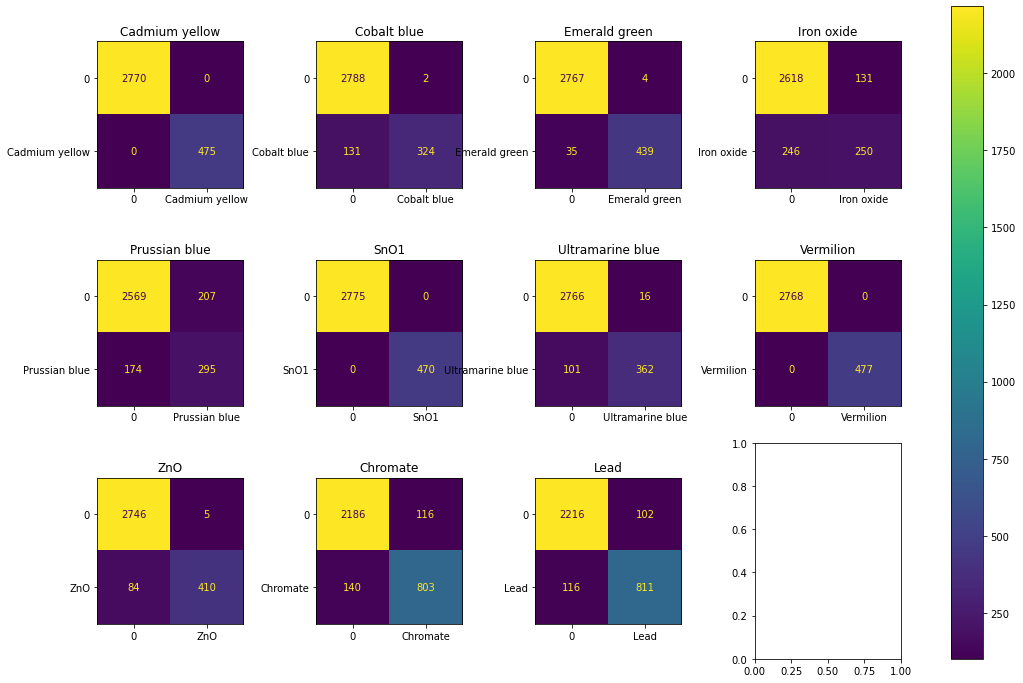

In [ ]:
f, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.ravel()
for i in range(11):
    disp = ConfusionMatrixDisplay(cm[i,:,:],
                                  display_labels=[0, gt.columns[i]])
    disp.plot(ax=axes[i], values_format= '.4g')
    disp.ax_.set_title('{}'.format(gt.columns[i]))
    disp.ax_.set_xlabel('')
    disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()
#     disp.plot()

plt.subplots_adjust(wspace=0.5, hspace=0.01)
f.colorbar(disp.im_, ax = axes)
plt.show()